<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install mpi4py

In [3]:
import subprocess
import matplotlib.pyplot as plt
import tqdm
import numpy as np

In [21]:
means = []
stds = []
for p in tqdm.trange(1, 8):
    o = subprocess.run(
        ["mpirun","--allow-run-as-root","-n", str(p), "python3", "task8.py", '-s', '4096', '-i', '50'], 
        universal_newlines=True, 
        stdout=subprocess.PIPE, 
        stderr=subprocess.PIPE)
    res = list(map(float, o.stdout.strip().split(' ')))
    means.append(res[0])
    stds.append(res[1])

100%|██████████| 7/7 [02:22<00:00, 20.34s/it]


In [20]:
! mpirun --allow-run-as-root -n  1 python3 task8.py -s 4096 -i 50

0.49436661720275876 0.01163102148786535


In [22]:
means = np.array(means)

Text(0, 0.5, 'Speedup')

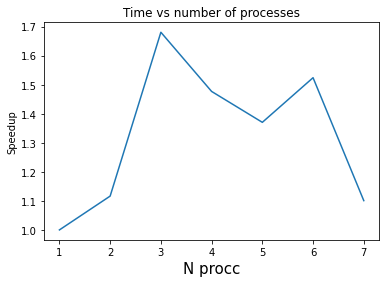

In [23]:
plt.plot(range(1, 8), means[0] / means )
plt.title('Time vs number of processes')
plt.xlabel('N procc', size=15)
plt.ylabel('Speedup')

In [2]:
%%writefile task8.py

from mpi4py import MPI
import numpy as np
import argparse
import time
# import tracemalloc

comm = MPI.COMM_WORLD
w_size = comm.Get_size() # new: gives number of ranks in comm
rank = comm.Get_rank()
IS_MASTER = rank == 0

parser = argparse.ArgumentParser('Task8')
parser.add_argument('-s', type=int, default=2**12, help='size of image')
parser.add_argument('-i', type=int, default=50, help='num iters')
FLAGS = parser.parse_args()
FLAGS.s = (FLAGS.s // w_size) * w_size

numDataPerRank = FLAGS.s // w_size  
data = None
received_data = None
if IS_MASTER:
    # data = np.random.randint(0,2,(FLAGS.s, FLAGS.s))
    data = np.eye(FLAGS.s, dtype=int)
    received_data = np.empty_like(data)
    # print(data)
received = np.empty((numDataPerRank, FLAGS.s), dtype=int) # allocate space for recvbuf

def roll(arr):
    # using not efficient function to show speedup
    res = np.empty_like(arr)
    w = arr.shape[1]
    for i in range(w):
        res[:, (i + 5) % w] = arr[:, i]
    return res
# tracemalloc.start()

times = []
for i in range(FLAGS.i):
    start = time.time()
    comm.Scatter(data, received, root=0)
    received_rolled = roll(received)
    comm.Gather(received_rolled, received_data, root=0)
    end = time.time()
    times.append(end - start)

if IS_MASTER:
    # current, peak = tracemalloc.get_traced_memory()
    # print("Curr: {:.3f}. Peak: {:.3f}".format(current / 2**10, peak / 2**10))
    print(np.mean(times), np.std(times))

# if IS_MASTER:
#     print(received_data)

Writing task8.py
